## Style Transfer

In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.python.keras import models
import IPython.display

In [ ]:
class style_transfer():
    def __init__(self, style_layers, content_layers):
        self.model = self.vgg_get_layers(style_layers+content_layers)
        self.num_style_layers = len(style_layers)
        self.opt = tf.optimizers.Adam(learning_rate=5, beta_1=0.99, epsilon=1e-1)
        self.imgs = []
        self.style_target = []
        self.best_img = None

    def vgg_get_layers(self, layers): # Function to define the style transfer model
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False
        layer_outputs = [vgg.get_layer(l).output for l in layers]
        tr_model = tf.keras.Model(vgg.input, layer_outputs)
        return tr_model

    def img_to_arr(self, img_path):
        max_dim = 512
        arr=Image.open(img_path)
        max_size = max(arr.size)
        scale = max_dim/max_size
        arr = arr.resize((round(arr.size[0]*scale), round(arr.size[1]*scale)), Image.ANTIALIAS)
        arr = np.asarray(arr)
        arr = np.expand_dims(arr, axis=0)
        arr = tf.keras.applications.vgg19.preprocess_input(arr)
        return arr

    def gram_matrix(self, mat):
        n = int(mat.shape[-1])
        p = tf.reshape(mat, [-1,n])
        nn = tf.shape(p)[0]
        return tf.matmul(tf.transpose(p),p)/ tf.cast(nn, tf.float32)

    def content_loss(self, base):
        return 0.5*tf.reduce_mean(tf.square(self.content_target[0]-base))

    def style_loss(self, target, base):
        gram_base = self.gram_matrix(base)
        return tf.reduce_mean(tf.square(gram_base-target))

    def transfer_loss(self, base):
        s_loss = 0
        c_loss = 0
        outp = self.model(base)
        style_base = outp[:self.num_style_layers]
        content_base = outp[self.num_style_layers:]
        for i in range(0, self.count_styles):
            u = self.num_style_layers*i+4
            l = self.num_style_layers*i
            for j, (target, base) in enumerate(zip(self.style_gram_matrices[l:u+1], style_base)):
                if self.style_layer_weights==None:
                      s_loss += self.style_img_wts[i]*(1/self.num_style_layers)*self.style_loss(target, base[0]) # Combined loss from all style layers
                else:
                      s_loss += self.style_img_wts[i]*self.style_layer_weights[j]*self.style_loss(target, base[0])
        for base in (content_base):
                c_loss += self.content_loss(base[0])
        y_var = tf.abs(base[:,:-1,:,:] - base[:,1:,:,:])
        x_var = tf.abs(base[:,:,:-1,:] - base[:,:,1:,:])
        t_loss = self.style_loss_wt*s_loss + self.content_loss_wt*c_loss + tf.reduce_sum(x_var) + tf.reduce_sum(y_var)
        return self.style_loss_wt*s_loss, self.content_loss_wt*c_loss, t_loss

    def img_plot(self, x, iter, s_loss, c_loss, t_loss):
        img = x.numpy()
        img[:, :, 0] += 103.939
        img[:, :, 1] += 116.779
        img[:, :, 2] += 123.68
        img = img[:, :, ::-1]
        img = np.clip(img, 0, 255).astype('uint8')
        f, ax = plt.subplots(figsize=(12,10))
        IPython.display.clear_output(wait=True)
        ax.matshow(img)
        #ax.set_title(f'Iteration={iter} \n Style_loss={s_loss}, Content_loss={c_loss}, Total_loss={t_loss}')
        plt.show()
        return

    def back_prop(self, base, iter):
        vgg_std_pix = np.array([103.939, 116.779, 123.68])
        pix_min = -vgg_std_pix
        pix_max = 255 - vgg_std_pix
        best_loss = float('inf')
        for i in range(0, iter):
            with tf.GradientTape() as g:
                loss = self.transfer_loss(base)
                grad = g.gradient(loss[2], base)
                self.opt.apply_gradients([(grad, base)])
                base.assign(tf.clip_by_value(base, pix_min, pix_max))

            if loss[2]<best_loss:
                best_loss = loss[2]
                self.best_img = base[0]
            self.img_plot(base[0], i, loss[0], loss[1], loss[2])

    def __call__(self, content_img, style_img, content_wt, style_wt, iter, style_img_wts=None, style_layer_weights=None):
        base_img = tf.Variable(self.img_to_arr(content_img))
        self.style_loss_wt = style_wt
        self.content_loss_wt = content_wt
        self.content_target = self.model(self.img_to_arr(content_img))[self.num_style_layers:] # content target
        self.count_styles = len(style_img)
        self.style_layer_weights = style_layer_weights
        if style_img_wts==None:
            self.style_img_wts = []
            for i in range(0, len(style_img)):
                self.style_img_wts.append(1/len(style_img))
        else:
            self.style_img_wts = style_img_wts
        for i in range(0, len(style_img)):
            self.style_target.append(self.model(self.img_to_arr(style_img[i]))[:self.num_style_layers]) # style target
        self.style_gram_matrices=[]
        for i in range(0, len(style_img)):
            for style in self.style_target[i]:
              self.style_gram_matrices.append(self.gram_matrix(style))
        self.back_prop(base_img, iter)

In [ ]:
content_layers = ['block5_conv2']
style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
    ]

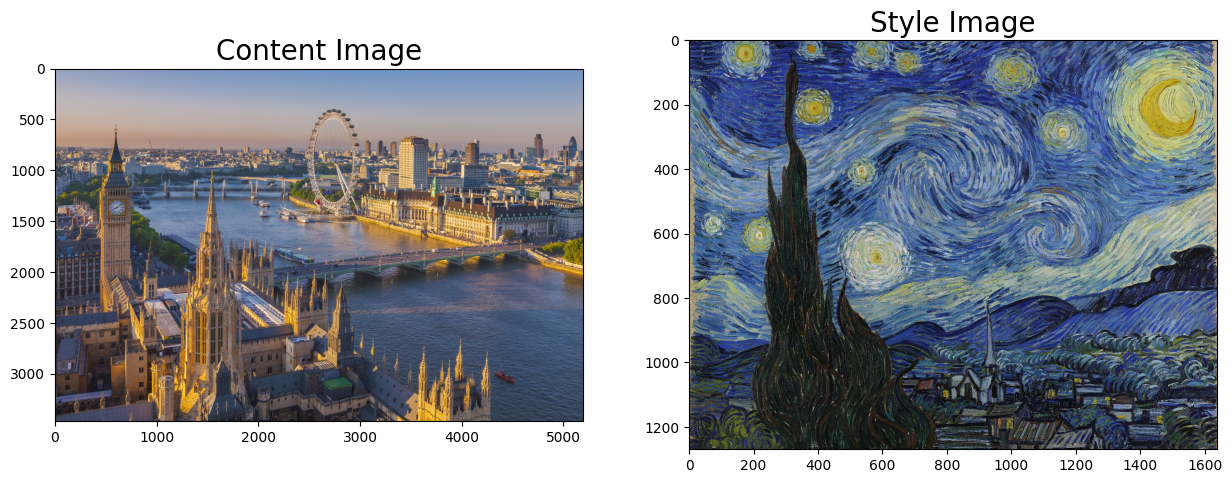

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Content Image', fontsize=20)
img_content = Image.open('/content/london.jpg')
plt.imshow(img_content)

plt.subplot(1,2,2)
plt.title('Style Image', fontsize=20)
img_style = Image.open('/content/starry_night.jpg')
plt.imshow(img_style)

plt.show()

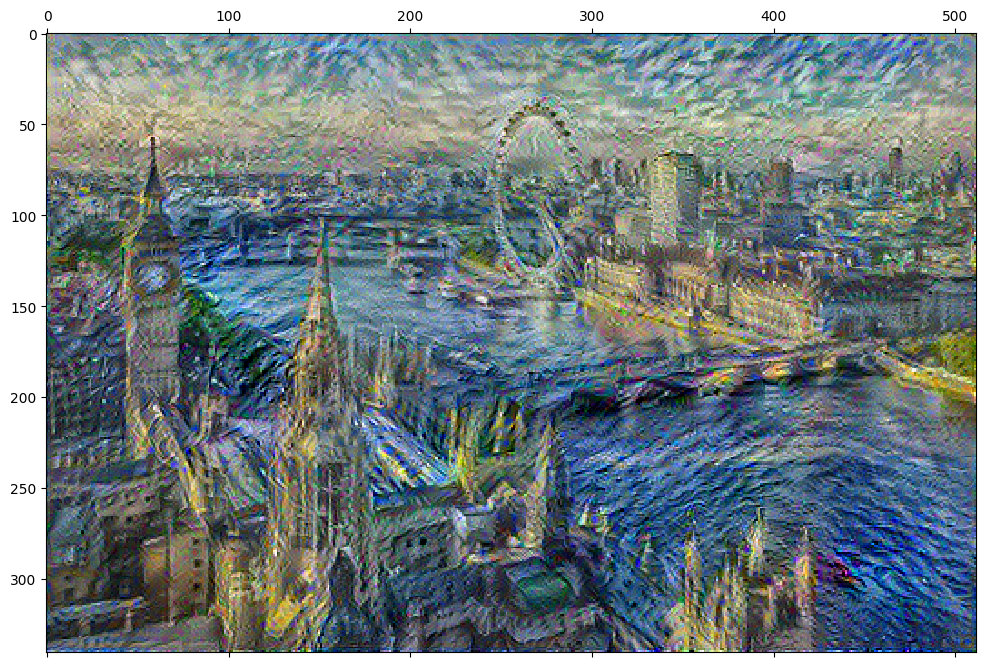

In [ ]:
content = '/content/london.jpg'
style = '/content/starry_night.jpg'

nst = style_transfer(style_layers, content_layers)
nst(content, [style], 100000, 0.005, 500)

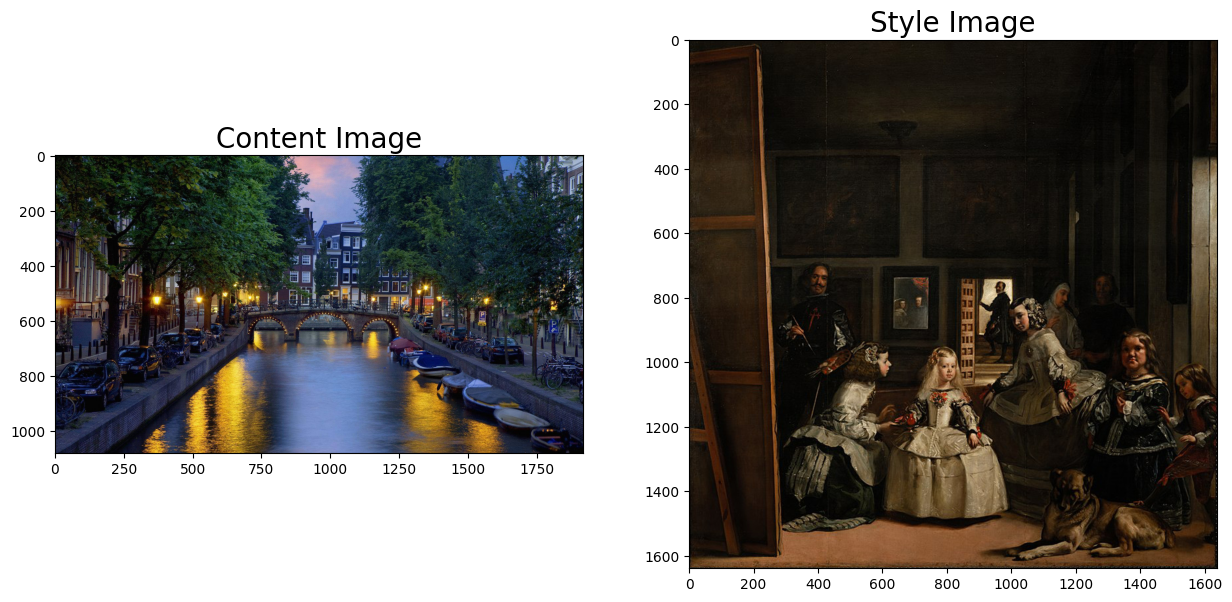

In [ ]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.title('Content Image', fontsize=20)
img_content = Image.open('/content/amsterdam.jpg')
plt.imshow(img_content)

plt.subplot(1,2,2)
plt.title('Style Image', fontsize=20)
img_style = Image.open('/content/las_meninas.jpg')
plt.imshow(img_style)

plt.show()

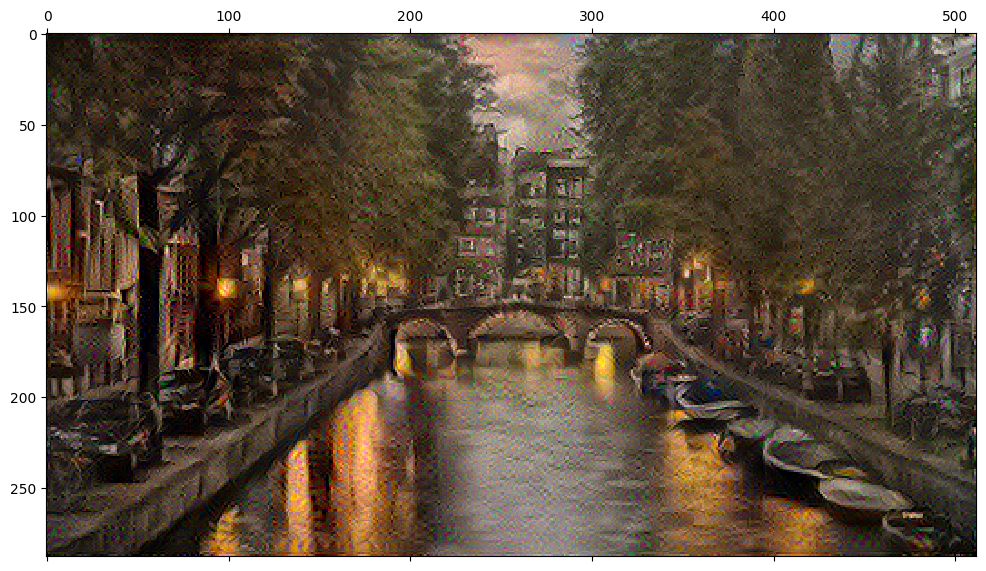

In [ ]:
content = '/content/amsterdam.jpg'
style = '/content/las_meninas.jpg'

nst=style_transfer(style_layers,content_layers)
nst(content, [style], 100000, 0.005, 500)

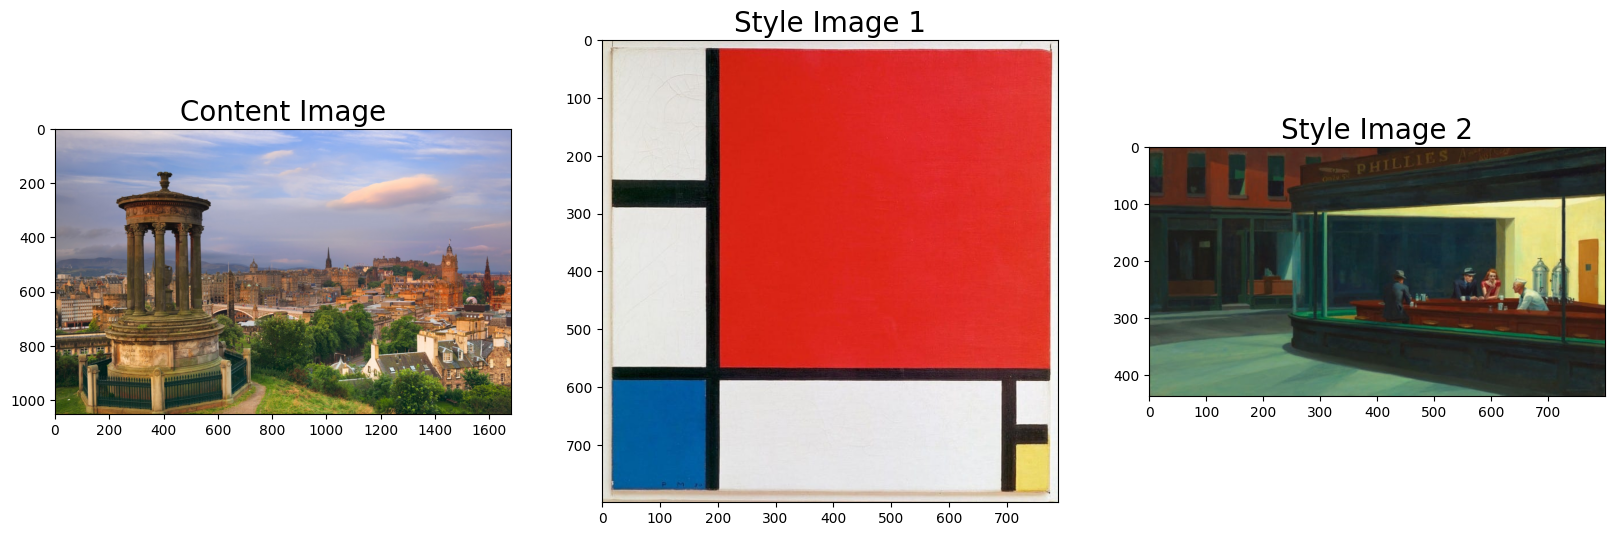

In [ ]:
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title('Content Image', fontsize=20)
img_content = Image.open('/content/edinburgh.jpg')
plt.imshow(img_content)

plt.subplot(1,3,2)
plt.title('Style Image 1', fontsize=20)
img_style = Image.open('/content/style1.jpg')
plt.imshow(img_style)

plt.subplot(1,3,3)
plt.title('Style Image 2', fontsize=20)
img_style = Image.open('/content/style2.jpg')
plt.imshow(img_style)

plt.show()

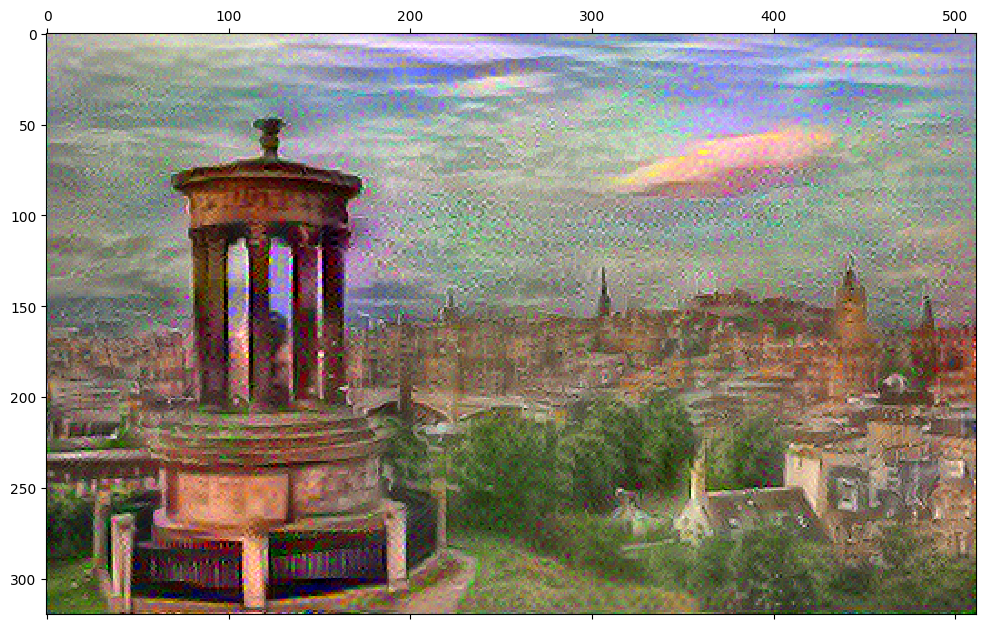

In [ ]:
content = '/content/edinburgh.jpg'
style1 = '/content/style1.jpg'
style2 = '/content/style2.jpg'

nst=style_transfer(style_layers,content_layers)
nst(content, [style1, style2], 100000, 0.005, 500)